In [1]:
from foundry.util.runtime import setup
setup()
import jax
print("Devices:", jax.devices())

from image_diffusion.main import logger
logger.setLevel('INFO')

Devices: [CudaDevice(id=0)]


In [1]:
import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train
from foundry.core.dataclasses import dataclass

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console

import matplotlib.pyplot as plt
from typing import Sequence

In [2]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

In [3]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image_diffusion/mnist-ddpm:v8")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

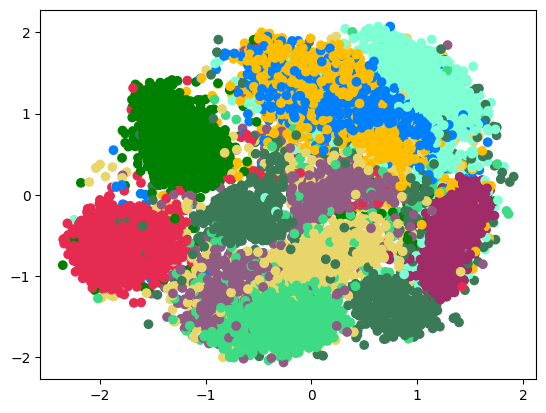

In [4]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())
if checkpoint.config.condition_type == "tsne":
    latents = test_data.cond
    encode = lambda x: x
    decode = lambda x: x
else:
    from latent_embed import train_embedding
    latents, encode, decode = train_embedding(
        test_data.cond, mode="tsne", 
        iterations=10_000
    )
embed_scatter(latents, test_data.label)

In [6]:
if checkpoint.config.condition_type == "image":
    from foundry.train.reporting import Image

    X, Y = npx.meshgrid(
        npx.linspace(-3, 3, 32),
        npx.linspace(-3, 3, 32)[::-1],
    )
    Z = npx.stack((X,Y), axis=-1)
    # (row, col, height, width, channel)
    images = F.vmap(F.vmap(decode))(Z)
    # (row, height, col, width, channel)
    images = npx.permute_dims(images, (0, 2, 1, 3, 4))
    Image(images.reshape((images.shape[0]*images.shape[1], images.shape[2]*images.shape[3], 1)))

In [ ]:
import foundry.diffusion.nonparametric as nonparametric
import functools

keypoints = train_data.cond[:32]

sample_conds = npx.stack(npx.meshgrid(
    npx.linspace(-2.5, 2.5, 10),
    npx.linspace(-2.5, 2.5, 10)
), -1)

@F.jit
def sample(N, vars, cond, rng_key):
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t - 1, cond=cond)
    sample = lambda rng_key: schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape))
    return F.vmap(sample, in_axes=(0))(foundry.random.split(rng_key, N))

@F.jit
def eval(vars, rng_key, cond, eval_sample, nw_samples):
    pass

@dataclass
class Evaluation:
    out_model: jax.Array
    out_nw: jax.Array
    out_keypoints: jax.Array
    err: jax.Array

sample_conds_flat = sample_conds.reshape((-1, 2))

batch_size = 32
eval_samples = []
nw_samples = []
rng = foundry.random.PRNGSequence(0)
for i in range(0, len(sample_conds_flat), batch_size):
    logger.info(f"Sampling at condition {i} of {len(sample_conds_flat)}")
    samples = sample_conds_flat[i:i+batch_size]
    eval_samples = F.vmap(sample, in_axes=(None, None, 0, 0))(8, vars, samples, foundry.random.split(next(rng), samples.shape[0]))
    nw_samples = F.vmap(sample, in_axes=(None, None, 0, 0))(32, vars, samples, foundry.random.split(next(rng), samples.shape[0]))

eval_samples = npx.concatenate(eval_samples, 0)
eval_samples.reshape(sample_conds.shape[0:1] + (-1,) + eval_samples.shape[1:])
nw_samples = npx.concatenate(eval_samples, 0)
nw_samples = nw_samples.reshape(sample_conds.shape[0:1] + (-1,) + nw_samples.shape[1:])


    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t - 1, cond=cond)
    samples_rng, ref_rng = foundry.random.split(rng_key)
    ref_sample = sample(ref_rng)
    samples = jax.lax.map(sample, foundry.random.split(samples_rng, 32))
    # noise the reference sample to some level
    # t = jax.random.randint(rng_key, (), 1, schedule.num_steps)
    t = npx.array(schedule.num_steps // 2)
    x_noised, _, _ = schedule.add_noise(rng_key, ref_sample, t)
    out_nw = schedule.output_from_denoised(
        x_noised, t,
        schedule.compute_denoised(
            x_noised, t, samples
    ))
    out_model = model.apply(vars, x_noised, t - 1, cond=cond)
    # apply the model, conditioned at the keypoints
    out_keypoints = jax.lax.map(
        lambda k: model.apply(vars, x_noised, t - 1, cond=k), 
        keypoints
    )
    err = npx.sqrt(npx.mean(npx.square(out_model - out_nw)))
    return EvalSample(
        cond=cond,
        x_noised=x_noised, t=t,
        out_model=out_model, out_nw=out_nw,
        out_keypoints=out_keypoints,
        err=err
    )

[12:52:38] INFO     image_diffusion - Sampling at condition 0 of 100


[12:52:42] INFO     image_diffusion - Sampling at condition 32 of 100
[12:52:44] INFO     image_diffusion - Sampling at condition 64 of 100
[12:52:47] INFO     image_diffusion - Sampling at condition 96 of 100
[12:52:49] INFO     image_diffusion - Evaluating error at condition points


TypeError: tree_map() missing 1 required positional argument: 'tree'

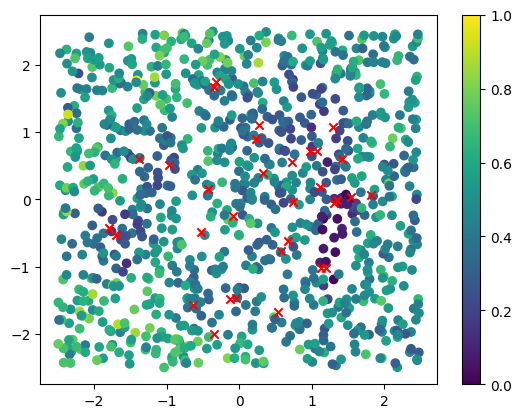

In [ ]:
plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=npx.clip(eval_samples.err, 0, 1))
# plot the keypoints
plt.scatter(keypoints[:,0], keypoints[:,1], c="red", marker="x")
plt.colorbar()

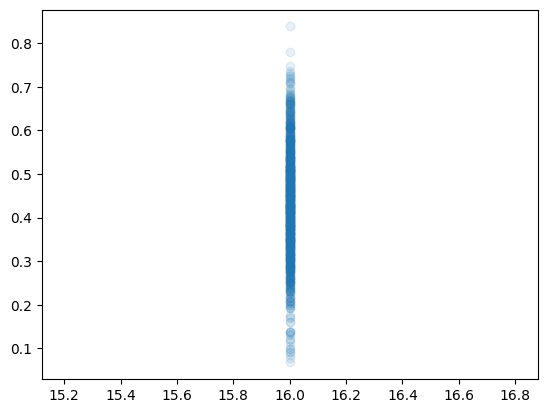

In [ ]:
plt.scatter(eval_samples.t, eval_samples.err.clip(0,10), alpha=0.1)

In [ ]:
def graph_smoothed(conds, errs, radius=0.2):
    xi = npx.linspace(-3,  3, 200)
    yi = npx.linspace(-3, 3, 200)
    def smooth(x, y):
        z = npx.stack((x,y), axis=-1)
        log_weights = -npx.sum(npx.square(z - conds), axis=-1)/radius**2
        log_norm = jax.scipy.special.logsumexp(log_weights)
        log_weights = log_weights - log_norm
        weights = npx.exp(log_weights)
        return npx.sum(weights * errs)
    zi = jax.vmap(jax.vmap(smooth))(*npx.meshgrid(xi, yi))
    plt.pcolormesh(xi, yi, zi, cmap="Greys")
    plt.ylim(-2., 2.75)
    plt.xlim(-2.75, 2.75)
    plt.colorbar()

graph_smoothed(eval_samples.cond, eval_samples.err.clip(0,1))
plt.title("MNIST Error wrt Denoising")
embed_scatter(latents, test_data.label, alpha=0.06, marker="x")

NameError: name 'eval_samples' is not defined

In [ ]:
USE_SOFTMAX = True
NUM_KEYPOINTS = 1
assert NUM_KEYPOINTS <= keypoints.shape[0]

In [ ]:
import foundry.train
import foundry.train.console
from foundry.train import LossOutput
from foundry.data import PyTreeData

import flax.linen as nn


class KeypointModel(nn.Module):
    @nn.compact
    def __call__(self, cond, t):
        input = npx.concatenate([t[None], cond])
        logits = nn.Sequential([
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(NUM_KEYPOINTS),
        ])(input)
        if USE_SOFTMAX:
            normalized = nn.softmax(logits, axis=-1)
        else:
            total = npx.sum(logits)
            normalized = logits + (1 - total)/logits.shape[0]
        return normalized

keypoint_model = KeypointModel()
keypoint_vars = keypoint_model.init(next(r), 
    npx.zeros((2,)), npx.zeros((), dtype=npx.int32)
)
iterations = 10_000
optimizer = optax.adamw(optax.cosine_decay_schedule(4e-3, iterations))
opt_state = optimizer.init(keypoint_vars["params"])

@foundry.train.batch_loss
def loss_fn(keypoint_vars, rng_key, sample : EvalSample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:NUM_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.mean(npx.square(interpolated - sample.out_model))
    return LossOutput(
        loss=err,
        metrics={"error": err}
    )

with foundry.train.loop(
    PyTreeData(eval_samples).stream().shuffle(foundry.random.key(42)).batch(128),
    iterations=iterations,
    rng_key=foundry.random.key(42)
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, keypoint_vars, metrics = foundry.train.step(
                loss_fn, optimizer, opt_state=opt_state,
                vars=keypoint_vars, rng_key=step.rng_key,
                batch=step.batch
            )
            if step.iteration % 100 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10000/10000 100% 0:00:00 0:00:31
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1429/1428   100% 0:00:00 0:00:31
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4         100% 0:00:00 0:00:00


[12:23:26] INFO     foundry.train -      0 | error: 0.012550616636872292
[12:23:27] INFO     foundry.train -    100 | error: 0.01260383240878582
           INFO     foundry.train -    200 | error: 0.012228317558765411
[12:23:28] INFO     foundry.train -    300 | error: 0.013643203303217888
           INFO     foundry.train -    400 | error: 0.012573473155498505
           INFO     foundry.train -    500 | error: 0.014042987488210201
[12:23:29] INFO     foundry.train -    600 | error: 0.011961989104747772
           INFO     foundry.train -    700 | error: 0.0134448716416955
           INFO     foundry.train -    800 | error: 0.012375888414680958
           INFO     foundry.train -    900 | error: 0.014492714777588844
[12:23:30] INFO     foundry.train -   1000 | error: 0.012124544009566307
           INFO     foundry.train -   1100 | error: 0.013631424866616726
           INFO     foundry.train -   1200 | error: 0.012472164817154408
[12:23:31] INFO     foundry.train -   1300 | error: 0.

In [ ]:
logger.info("Evaluating samples")
def eval(sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:NUM_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    # interpolated = sample.out_keypoints[0]
    # interpolated = model.apply(vars, sample.x_noised, sample.t - 1, cond=keypoints[0])
    err = npx.sqrt(npx.mean(npx.square(interpolated - sample.out_model)))
    return err
keypoint_errs = jax.lax.map(eval, eval_samples, batch_size=1024)

           INFO     image_diffusion - Evaluating samples


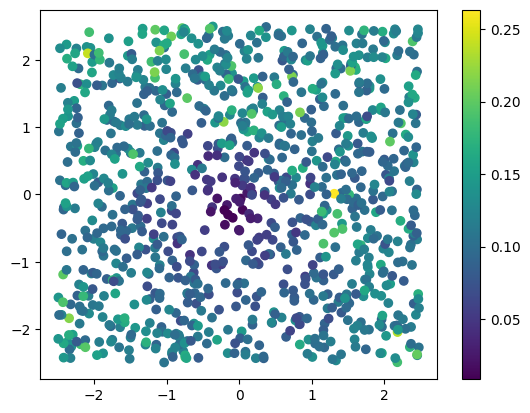

In [ ]:
plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=npx.clip(keypoint_errs, 0, 1))
plt.colorbar()

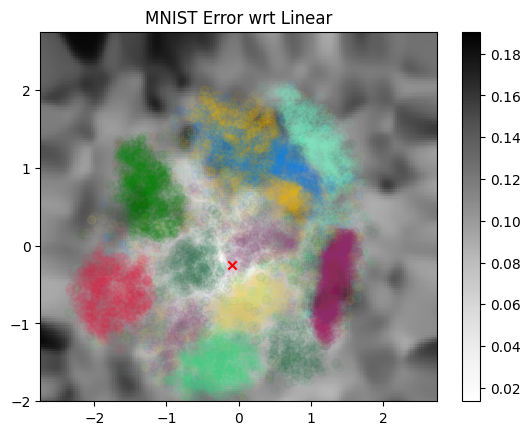

In [ ]:
graph_smoothed(eval_samples.cond, keypoint_errs, 0.15)
plt.title("MNIST Error wrt Linear")
embed_scatter(latents, test_data.label, alpha=0.05)
plt.scatter(keypoints[:NUM_KEYPOINTS,0], keypoints[:NUM_KEYPOINTS,1], c="red", marker="x")